In [30]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator


In [2]:
# Define the path to the 'rating' subfolder
rating_folder_path = "../results/rating"

# Recursively list all csv files in the 'free' folder
csv_files = []
for root, dirs, files in os.walk(rating_folder_path):
    for file in files:
        if file.endswith(".csv"):
            csv_files.append(os.path.join(root, file))

# Read and concatenate all CSV files
dfs = [pd.read_csv(csv_file) for csv_file in csv_files]
concatenated_df = pd.concat(dfs, ignore_index=True)

# Display the shape and a sample of the concatenated DataFrame
shape = concatenated_df.shape
sample_data = concatenated_df.head()

shape, sample_data

((7692, 17),
                  model_name  temperature  seed  item_id       phenomenon  \
 0  meta-llama/Llama-2-7b-hf          0.1     0        1  indirect_speech   
 1  meta-llama/Llama-2-7b-hf          0.1     0        1  indirect_speech   
 2  meta-llama/Llama-2-7b-hf          0.1     0        1  indirect_speech   
 3  meta-llama/Llama-2-7b-hf          0.1     0        1  indirect_speech   
 4  meta-llama/Llama-2-7b-hf          0.1     0        2  indirect_speech   
 
                                               prompt  \
 0  You will read a short story that describes an ...   
 1  You will read a short story that describes an ...   
 2  You will read a short story that describes an ...   
 3  You will read a short story that describes an ...   
 4  You will read a short story that describes an ...   
 
                                         prior_prompt question  \
 0  You will read a short story that describes an ...      NaN   
 1  You will read a short story that describes 

In [3]:
# Checking for NA values in the concatenated DataFrame
na_values = concatenated_df.isnull().sum()

na_values


model_name                       0
temperature                      0
seed                             0
item_id                          0
phenomenon                       0
prompt                           0
prior_prompt                     0
question                      5820
options                          0
option_names                     0
scale                            0
rating_options                   0
weighted_options                 0
chosen_option                    0
token_cond_log_probs             0
prior_token_log_probs            0
null_prior_token_log_probs       0
dtype: int64

In [13]:
# Grouping by the specified columns and calculating mean and standard deviation for 'weighted_options'
grouped_df = concatenated_df.groupby(['phenomenon', 'option_names', 'item_id', 'model_name', 'scale'])['weighted_options'].agg(['mean'])

grouped_df.reset_index(inplace=True)
grouped_df.head()


print(grouped_df.shape)
print(grouped_df.isnull().sum())
print(grouped_df.head())

(7692, 6)
phenomenon      0
option_names    0
item_id         0
model_name      0
scale           0
mean            0
dtype: int64
  phenomenon option_names  item_id              model_name        scale  \
0  coherence   competitor        1       google/flan-t5-xl  appropriate   
1  coherence   competitor        1       google/flan-t5-xl       likely   
2  coherence   competitor        1       google/flan-t5-xl    plausible   
3  coherence   competitor        1       google/flan-t5-xl     possible   
4  coherence   competitor        1  gpt-3.5-turbo-instruct  appropriate   

      mean  
0  3.00000  
1  3.00000  
2  3.00000  
3  3.00000  
4  2.76909  


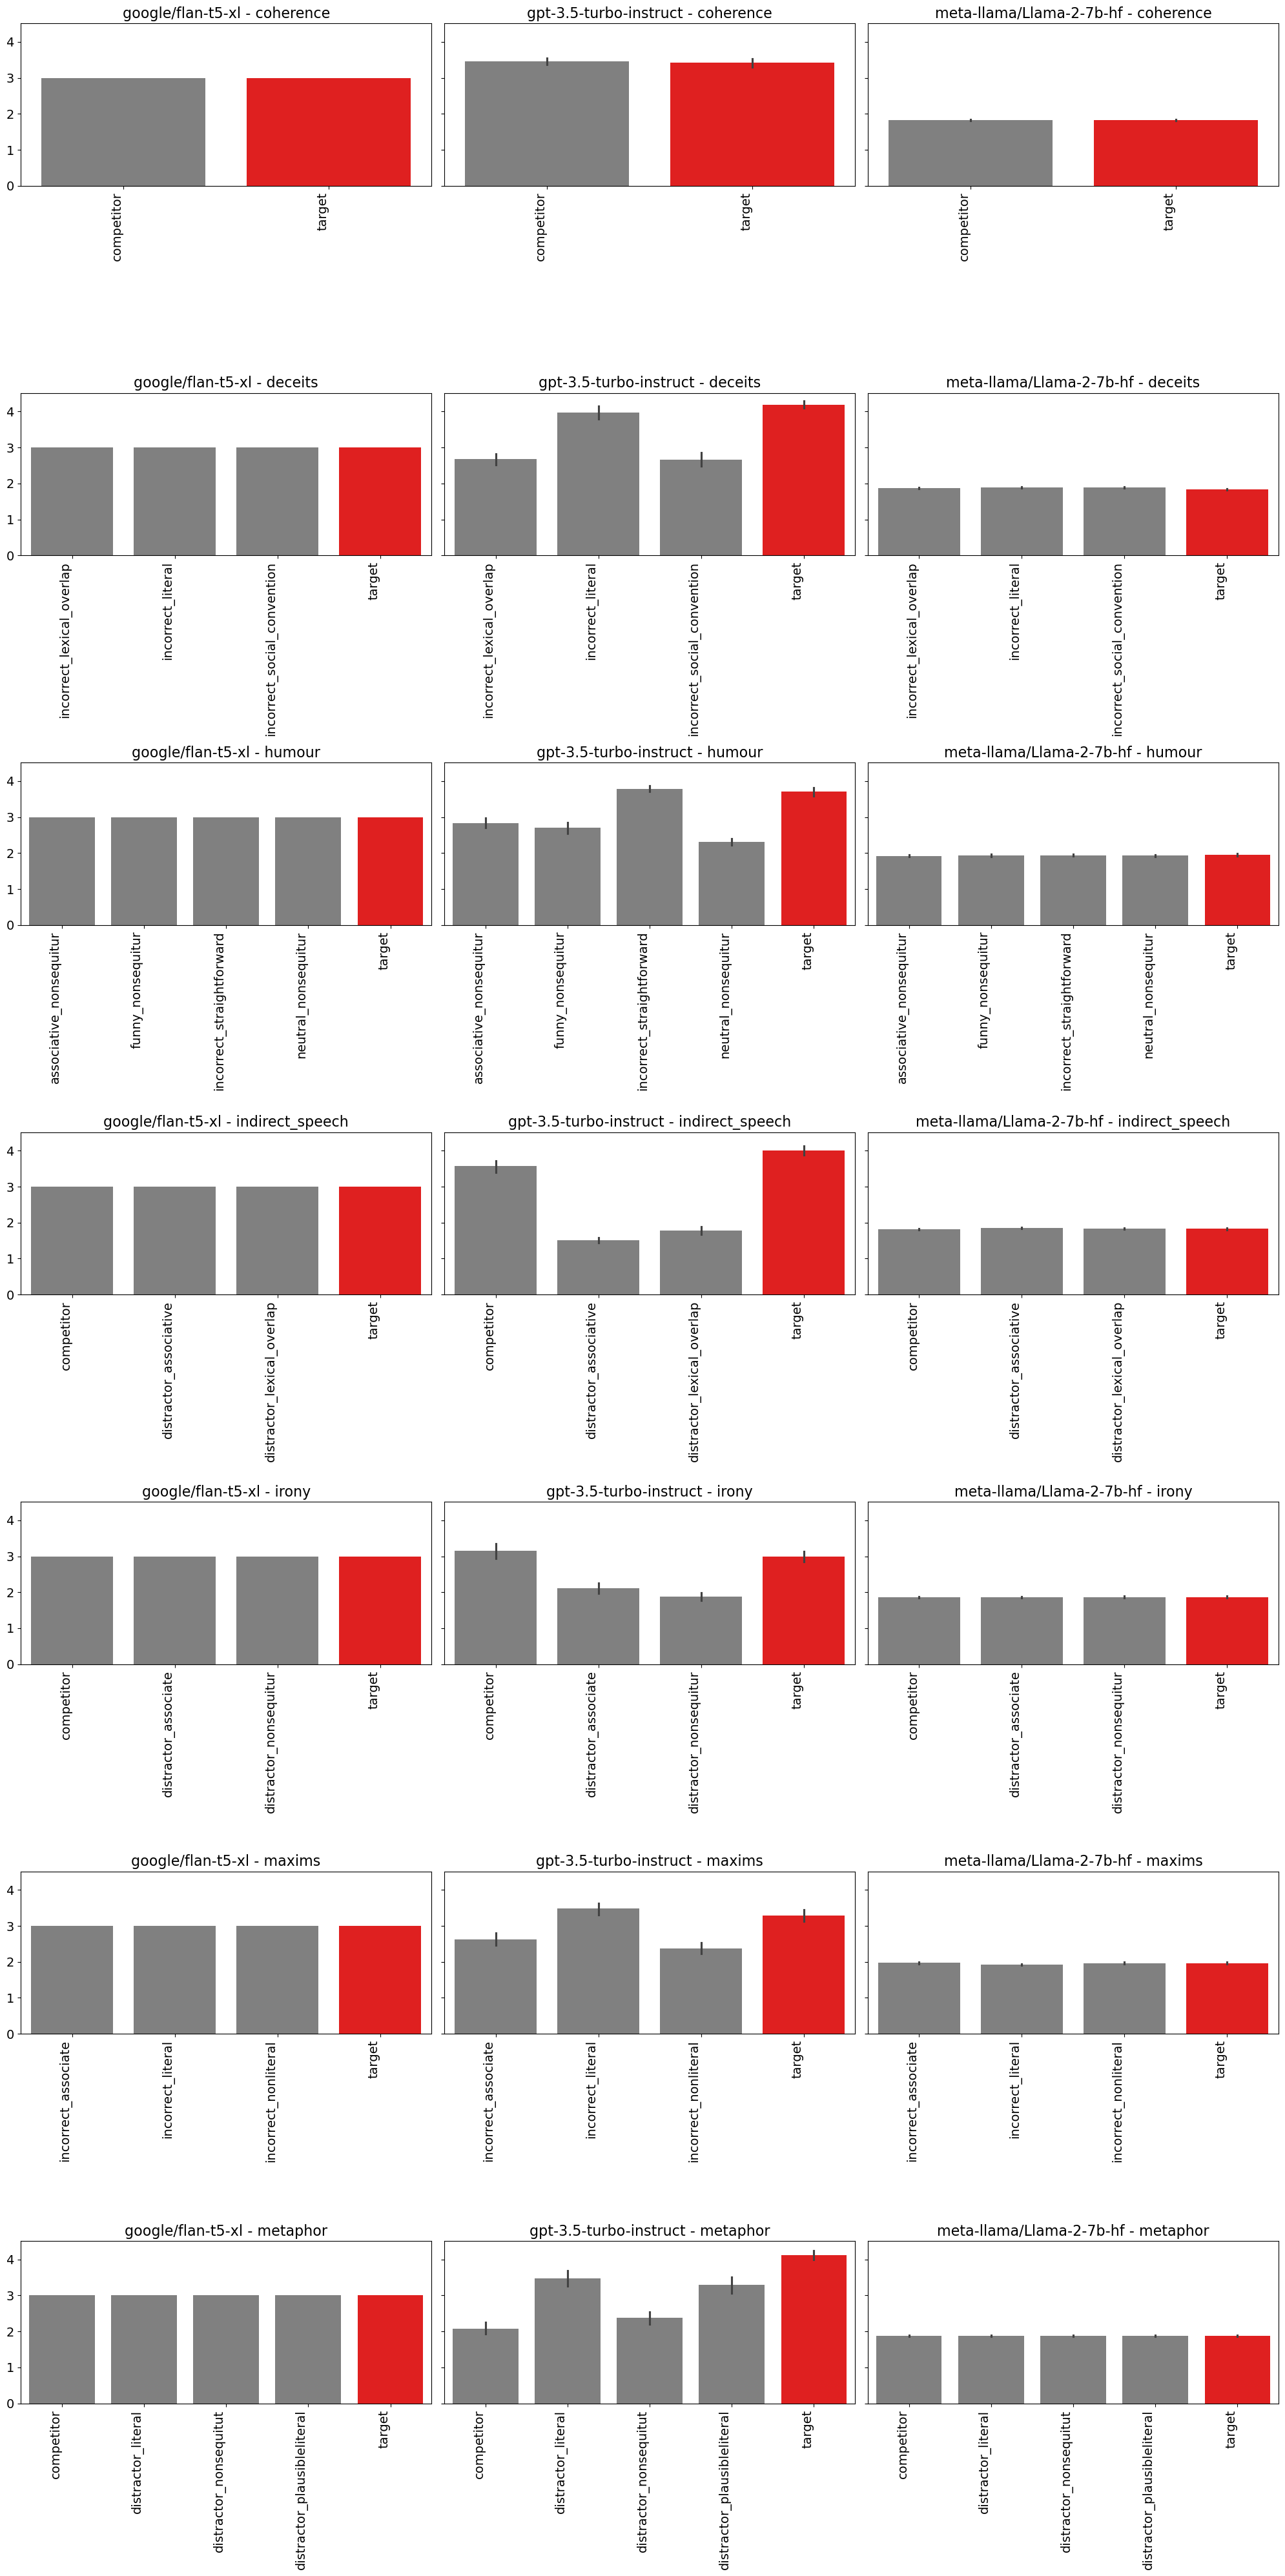

In [32]:
# Extracting unique models and phenomena based on the grouped data
unique_models = grouped_df['model_name'].unique()
unique_phenomena = grouped_df['phenomenon'].unique()

# Use a custom color palette to highlight 'target' response_option
palette = {response: 'gray' if response != 'target' else 'red' for response in grouped_df['option_names'].unique()}

# Set up the grid layout for the subplots
fig, axes = plt.subplots(len(unique_phenomena), len(unique_models), figsize=(20, 40), sharey=True)

# Iterate over each model and phenomenon to create individual subplots
for i, phenomenon in enumerate(unique_phenomena):
    for j, model in enumerate(unique_models):
        ax = axes[i, j]
        subset = grouped_df[(grouped_df['model_name'] == model) & (grouped_df['phenomenon'] == phenomenon)]
        if not subset.empty:
            sns.barplot(x='option_names', y='mean', data=subset, ax=ax, palette=palette, hue='option_names')
            ax.set_title(f'Model: {model} | Phenomenon: {phenomenon}')
            ax.set_xlabel('')
            ax.set_ylabel('')

            # Use FixedLocator to set ticks
            ax.xaxis.set_major_locator(FixedLocator(range(len(subset['option_names']))))
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
            ax.grid(True, axis='y')

            # Remove all lines on background
            ax.grid(False)
            #sns.despine(left=True, bottom=True, ax=ax)

            # Set title with larger font size
            ax.set_title(f"{model} - {phenomenon}", fontsize=16)
            
            # Increase tick label size
            ax.tick_params(axis="x", rotation=90, labelsize=14)
            ax.tick_params(axis="y", labelsize=14)
            
            # Increase axis label size
            ax.set_xlabel(ax.get_xlabel(), fontsize=14)
            ax.set_ylabel(ax.get_ylabel(), fontsize=14)

# Adjust layout
fig.tight_layout()
plt.show()


In [33]:
# Define the path to save the plot as PDF
save_path = "plots/rating_w.score_distribution_by_model_phenomenon.pdf"

# Ensure the directory exists
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the plot to the specified path
fig.savefig(save_path, bbox_inches='tight')

save_path


'plots/rating_w.score_distribution_by_model_phenomenon.pdf'

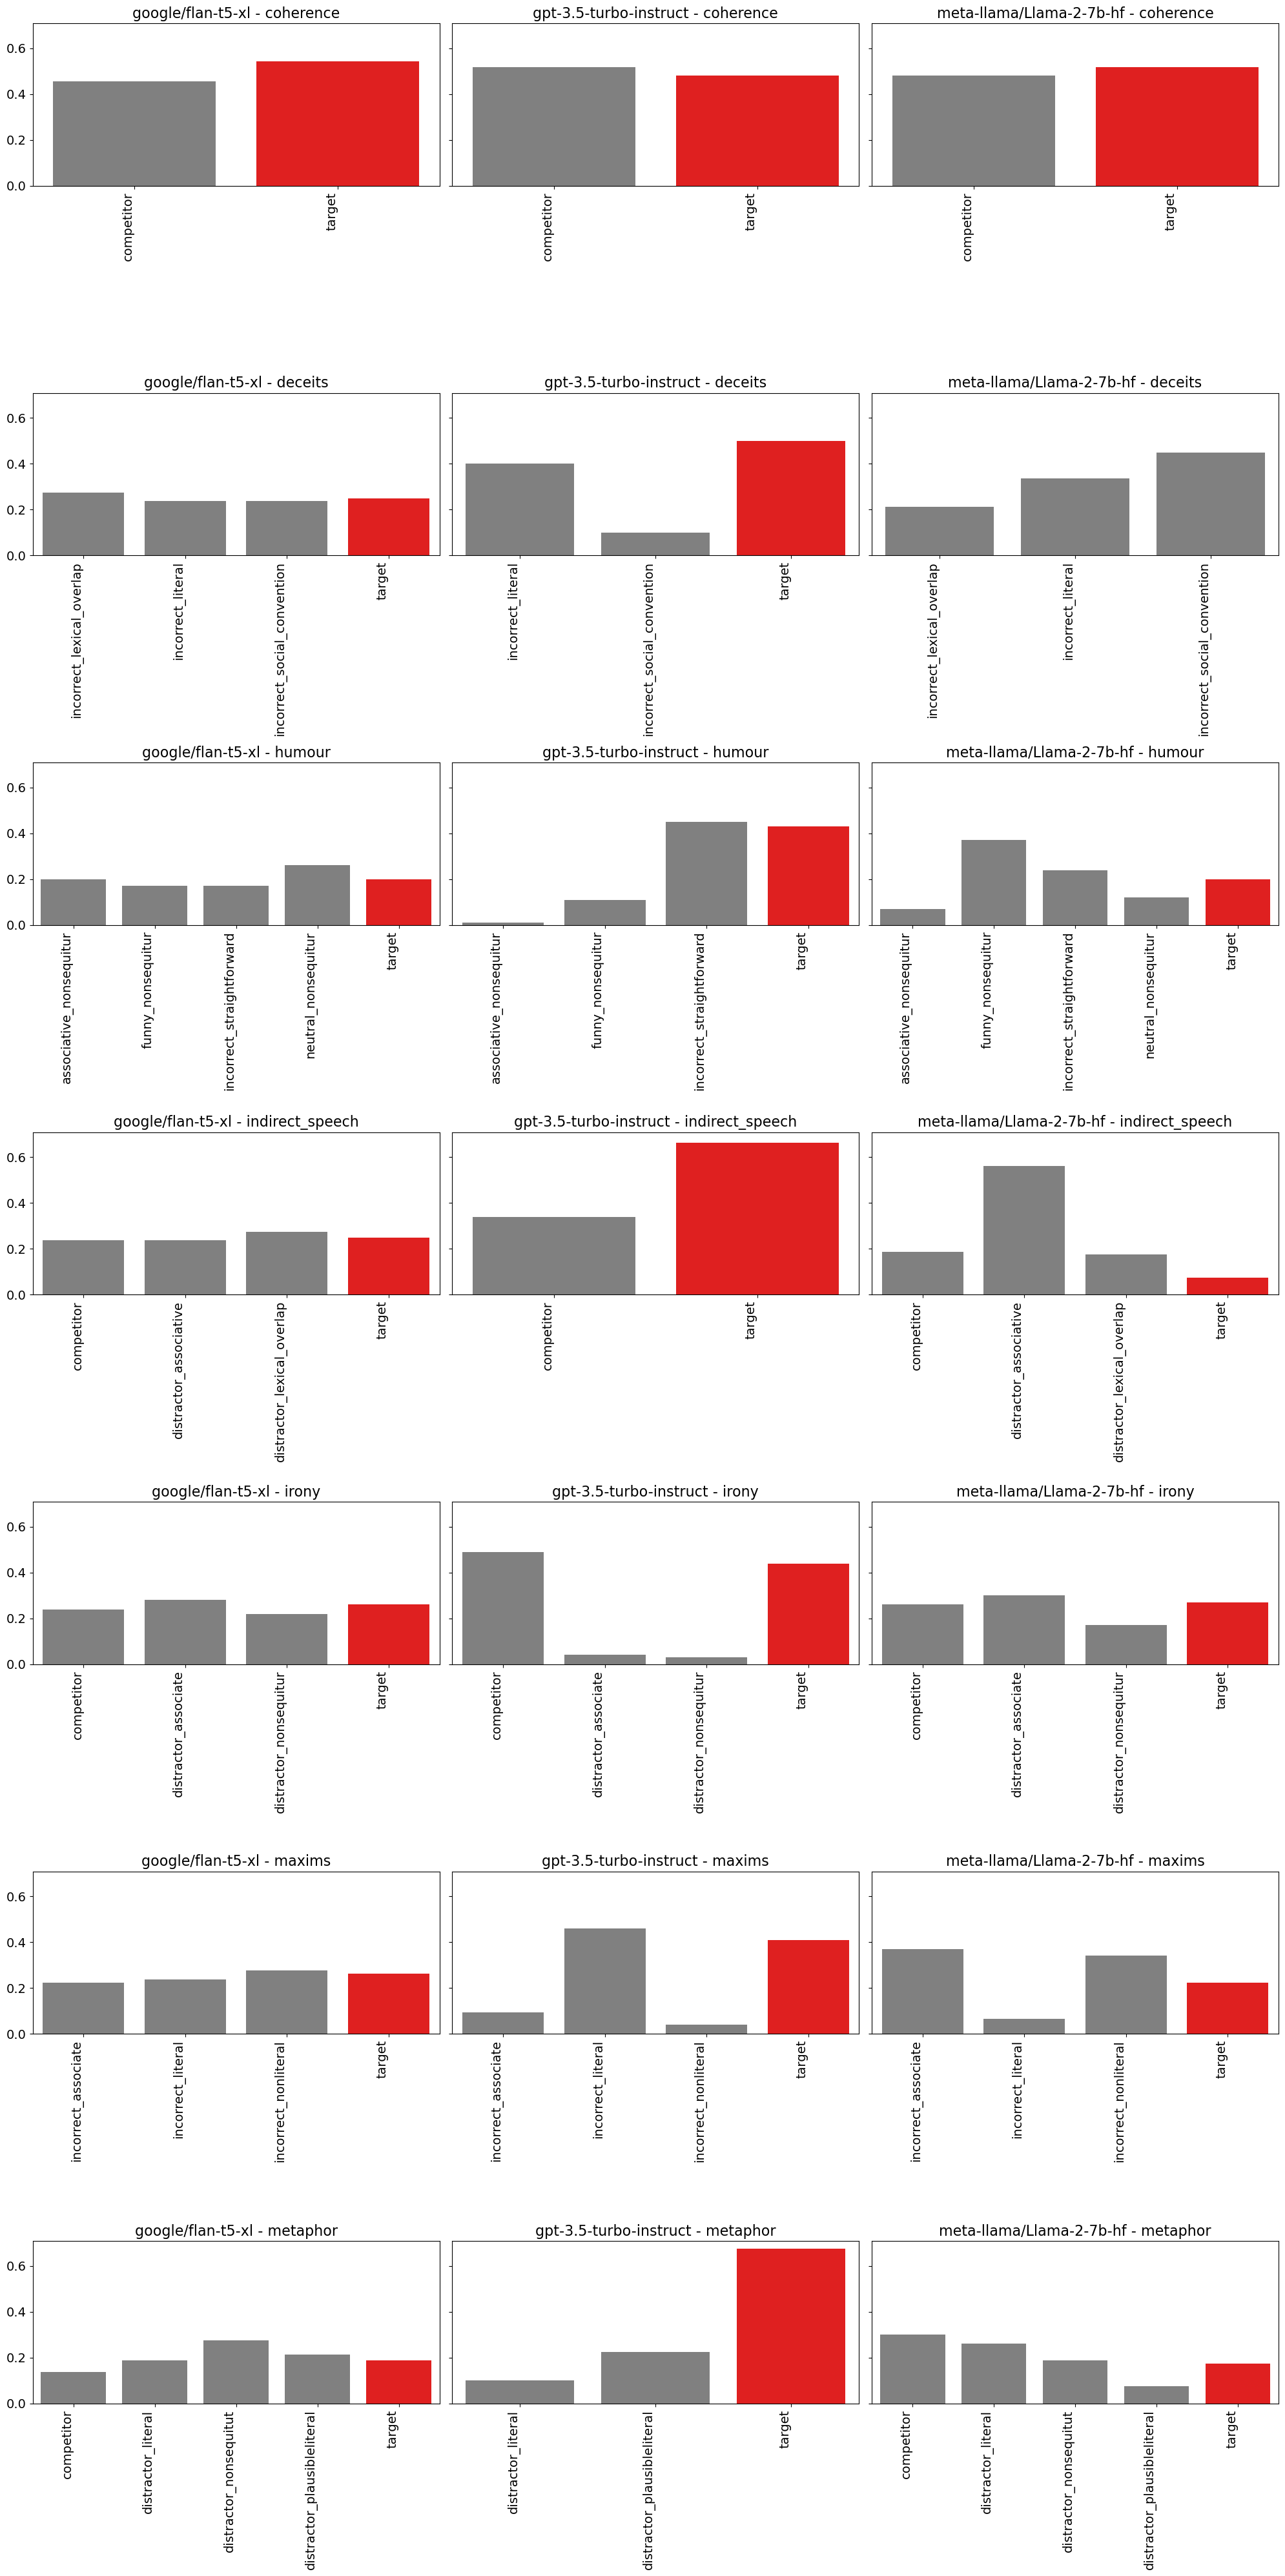

In [34]:
# Calculating the proportion of each chosen_option for each model and phenomenon combination
proportion_data = concatenated_df.groupby(['model_name', 'phenomenon', 'chosen_option']).size().reset_index(name='counts')

# Calculating the proportion of each chosen_option for each model and phenomenon combination again
total_counts = proportion_data.groupby(['model_name', 'phenomenon'])['counts'].transform('sum')
proportion_data['proportion'] = proportion_data['counts'] / total_counts

# Plotting the proportions
fig, axes = plt.subplots(len(unique_phenomena), len(unique_models), figsize=(20, 40), sharey=True)

for i, phenomenon in enumerate(unique_phenomena):
    for j, model in enumerate(unique_models):
        ax = axes[i, j]
        subset = proportion_data[(proportion_data['model_name'] == model) & (proportion_data['phenomenon'] == phenomenon)]
        if not subset.empty:
            sns.barplot(x='chosen_option', y='proportion', data=subset, ax=ax, palette=palette, hue='chosen_option')
            ax.set_title(f'Model: {model} | Phenomenon: {phenomenon}')
            ax.set_xlabel('')
            ax.set_ylabel('')

            
            # Use FixedLocator to set ticks
            ax.xaxis.set_major_locator(FixedLocator(range(len(subset['chosen_option']))))
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
            
            # Remove all lines on background
            ax.grid(False)
            #sns.despine(left=True, bottom=True, ax=ax)

            # Set title with larger font size
            ax.set_title(f"{model} - {phenomenon}", fontsize=16)
            
            # Increase tick label size
            ax.tick_params(axis="x", rotation=90, labelsize=14)
            ax.tick_params(axis="y", labelsize=14)
            
            # Increase axis label size
            ax.set_xlabel(ax.get_xlabel(), fontsize=14)
            ax.set_ylabel(ax.get_ylabel(), fontsize=14)

# Adjust layout
fig.tight_layout()
plt.show()


In [29]:
# Define the path to save the plot as PDF
save_path = "plots/rating_choosen_option_distribution_by_model_phenomenon.pdf"

# Ensure the directory exists
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the plot to the specified path
fig.savefig(save_path, bbox_inches='tight')

save_path


'plots/rating_choosen_option_distribution_by_model_phenomenon.pdf'

In [38]:
coherence_not_target_df = concatenated_df[(concatenated_df['phenomenon'] == 'coherence') & 
                                          (concatenated_df['chosen_option'] != 'target')]

coherence_not_target_df

,model_name,temperature,seed,item_id,phenomenon,prompt,prior_prompt,question,options,option_names,scale,rating_options,weighted_options,chosen_option,token_cond_log_probs,prior_token_log_probs,null_prior_token_log_probs
1307,meta-llama/Llama-2-7b-hf,0.1,0,1,coherence,You will read a pair of sentences. Your task i...,You will read a pair of sentences. Your task i...,Is this story coherent or not?,coherent,target,plausible,"very implausible, implausible, neutral, plausi...",1.809623,competitor,"[[-10.218891143798828, -4.771527290344238], [-...","[[-13.373932838439941, -2.9205374717712402], [...","[[-10.573612213134766, -4.82731294631958], [-1..."
1308,meta-llama/Llama-2-7b-hf,0.1,0,1,coherence,You will read a pair of sentences. Your task i...,You will read a pair of sentences. Your task i...,Is this story coherent or not?,incoherent,competitor,plausible,"very implausible, implausible, neutral, plausi...",1.834913,competitor,"[[-10.002084732055664, -4.478825092315674], [-...","[[-13.373932838439941, -2.9205374717712402], [...","[[-10.42076301574707, -4.460565567016602], [-1..."
1309,meta-llama/Llama-2-7b-hf,0.1,0,2,coherence,You will read a pair of sentences. Your task i...,You will read a pair of sentences. Your task i...,Is this story coherent or not?,coherent,target,plausible,"very implausible, implausible, neutral, plausi...",1.863317,competitor,"[[-10.314153671264648, -4.676219940185547], [-...","[[-13.373932838439941, -2.9205374717712402], [...","[[-10.573612213134766, -4.82731294631958], [-1..."
1310,meta-llama/Llama-2-7b-hf,0.1,0,2,coherence,You will read a pair of sentences. Your task i...,You will read a pair of sentences. Your task i...,Is this story coherent or not?,incoherent,competitor,plausible,"very implausible, implausible, neutral, plausi...",1.910462,competitor,"[[-10.134866714477539, -4.371182441711426], [-...","[[-13.373932838439941, -2.9205374717712402], [...","[[-10.42076301574707, -4.460565567016602], [-1..."
1311,meta-llama/Llama-2-7b-hf,0.1,0,3,coherence,You will read a pair of sentences. Your task i...,You will read a pair of sentences. Your task i...,Is this story coherent or not?,coherent,target,plausible,"very implausible, implausible, neutral, plausi...",1.835182,competitor,"[[-10.490863800048828, -4.660823822021484], [-...","[[-13.373932838439941, -2.9205374717712402], [...","[[-10.573612213134766, -4.82731294631958], [-1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5593,google/flan-t5-xl,0.1,0,35,coherence,You will read a pair of sentences. Your task i...,You will read a pair of sentences. Your task i...,Is this story coherent or not?,coherent,competitor,plausible,"very implausible, implausible, neutral, plausi...",3.000000,competitor,"[[-1.2671928405761719], [-1.2671928405761719],...","[[-3.409724473953247], [-1.9873242378234863], ...","[[-1.0759859085083008], [-1.0759859085083008],..."
5594,google/flan-t5-xl,0.1,0,36,coherence,You will read a pair of sentences. Your task i...,You will read a pair of sentences. Your task i...,Is this story coherent or not?,incoherent,target,plausible,"very implausible, implausible, neutral, plausi...",3.000000,competitor,"[[-1.1578481197357178], [-1.1578481197357178],...","[[-3.409724473953247], [-1.9873242378234863], ...","[[-1.5065852403640747], [-1.5065852403640747],..."
5595,google/flan-t5-xl,0.1,0,36,coherence,You will read a pair of sentences. Your task i...,You will read a pair of sentences. Your task i...,Is this story coherent or not?,coherent,competitor,plausible,"very implausible, implausible, neutral, plausi...",3.000000,competitor,"[[-1.5164527893066406], [-1.5164527893066406],...","[[-3.409724473953247], [-1.9873242378234863], ...","[[-1.0759859085083008], [-1.0759859085083008],..."
5598,google/flan-t5-xl,0.1,0,38,coherence,You will read a pair of sentences. Your task i...,You will read a pair of sentences. Your task i...,Is this story coherent or not?,incoherent,target,plausible,"very implausible, implausible, neutral

In [39]:
# Filtering the data for rows where option_names is 'target'
target_data = concatenated_df[concatenated_df['option_names'] == 'target']

# Grouping by scale, model_name, and phenomenon and calculating mean and standard deviation for weighted_options
grouped_target_data = target_data.groupby(['scale', 'model_name', 'phenomenon'])['weighted_options'].agg(['mean', 'std']).reset_index()

print(grouped_target_data.head())


         scale         model_name       phenomenon  mean  std
0  appropriate  google/flan-t5-xl        coherence   3.0  0.0
1  appropriate  google/flan-t5-xl          deceits   3.0  0.0
2  appropriate  google/flan-t5-xl           humour   3.0  0.0
3  appropriate  google/flan-t5-xl  indirect_speech   3.0  0.0
4  appropriate  google/flan-t5-xl            irony   3.0  0.0


In [ ]:
# Plotting the proportions
fig, axes = plt.subplots(len(unique_phenomena), len(unique_models), figsize=(20, 40), sharey=True)

for i, phenomenon in enumerate(unique_phenomena):
    for j, model in enumerate(unique_models):
        ax = axes[i, j]
        subset = proportion_data[(proportion_data['model_name'] == model) & (proportion_data['phenomenon'] == phenomenon)]
        if not subset.empty:
            sns.barplot(x='chosen_option', y='proportion', data=subset, ax=ax, palette=palette, hue='chosen_option')
            ax.set_title(f'Model: {model} | Phenomenon: {phenomenon}')
            ax.set_xlabel('')
            ax.set_ylabel('')

            
            # Use FixedLocator to set ticks
            ax.xaxis.set_major_locator(FixedLocator(range(len(subset['chosen_option']))))
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
            
            # Remove all lines on background
            ax.grid(False)
            #sns.despine(left=True, bottom=True, ax=ax)

            # Set title with larger font size
            ax.set_title(f"{model} - {phenomenon}", fontsize=16)
            
            # Increase tick label size
            ax.tick_params(axis="x", rotation=90, labelsize=14)
            ax.tick_params(axis="y", labelsize=14)
            
            # Increase axis label size
            ax.set_xlabel(ax.get_xlabel(), fontsize=14)
            ax.set_ylabel(ax.get_ylabel(), fontsize=14)

# Adjust layout
fig.tight_layout()
plt.show()

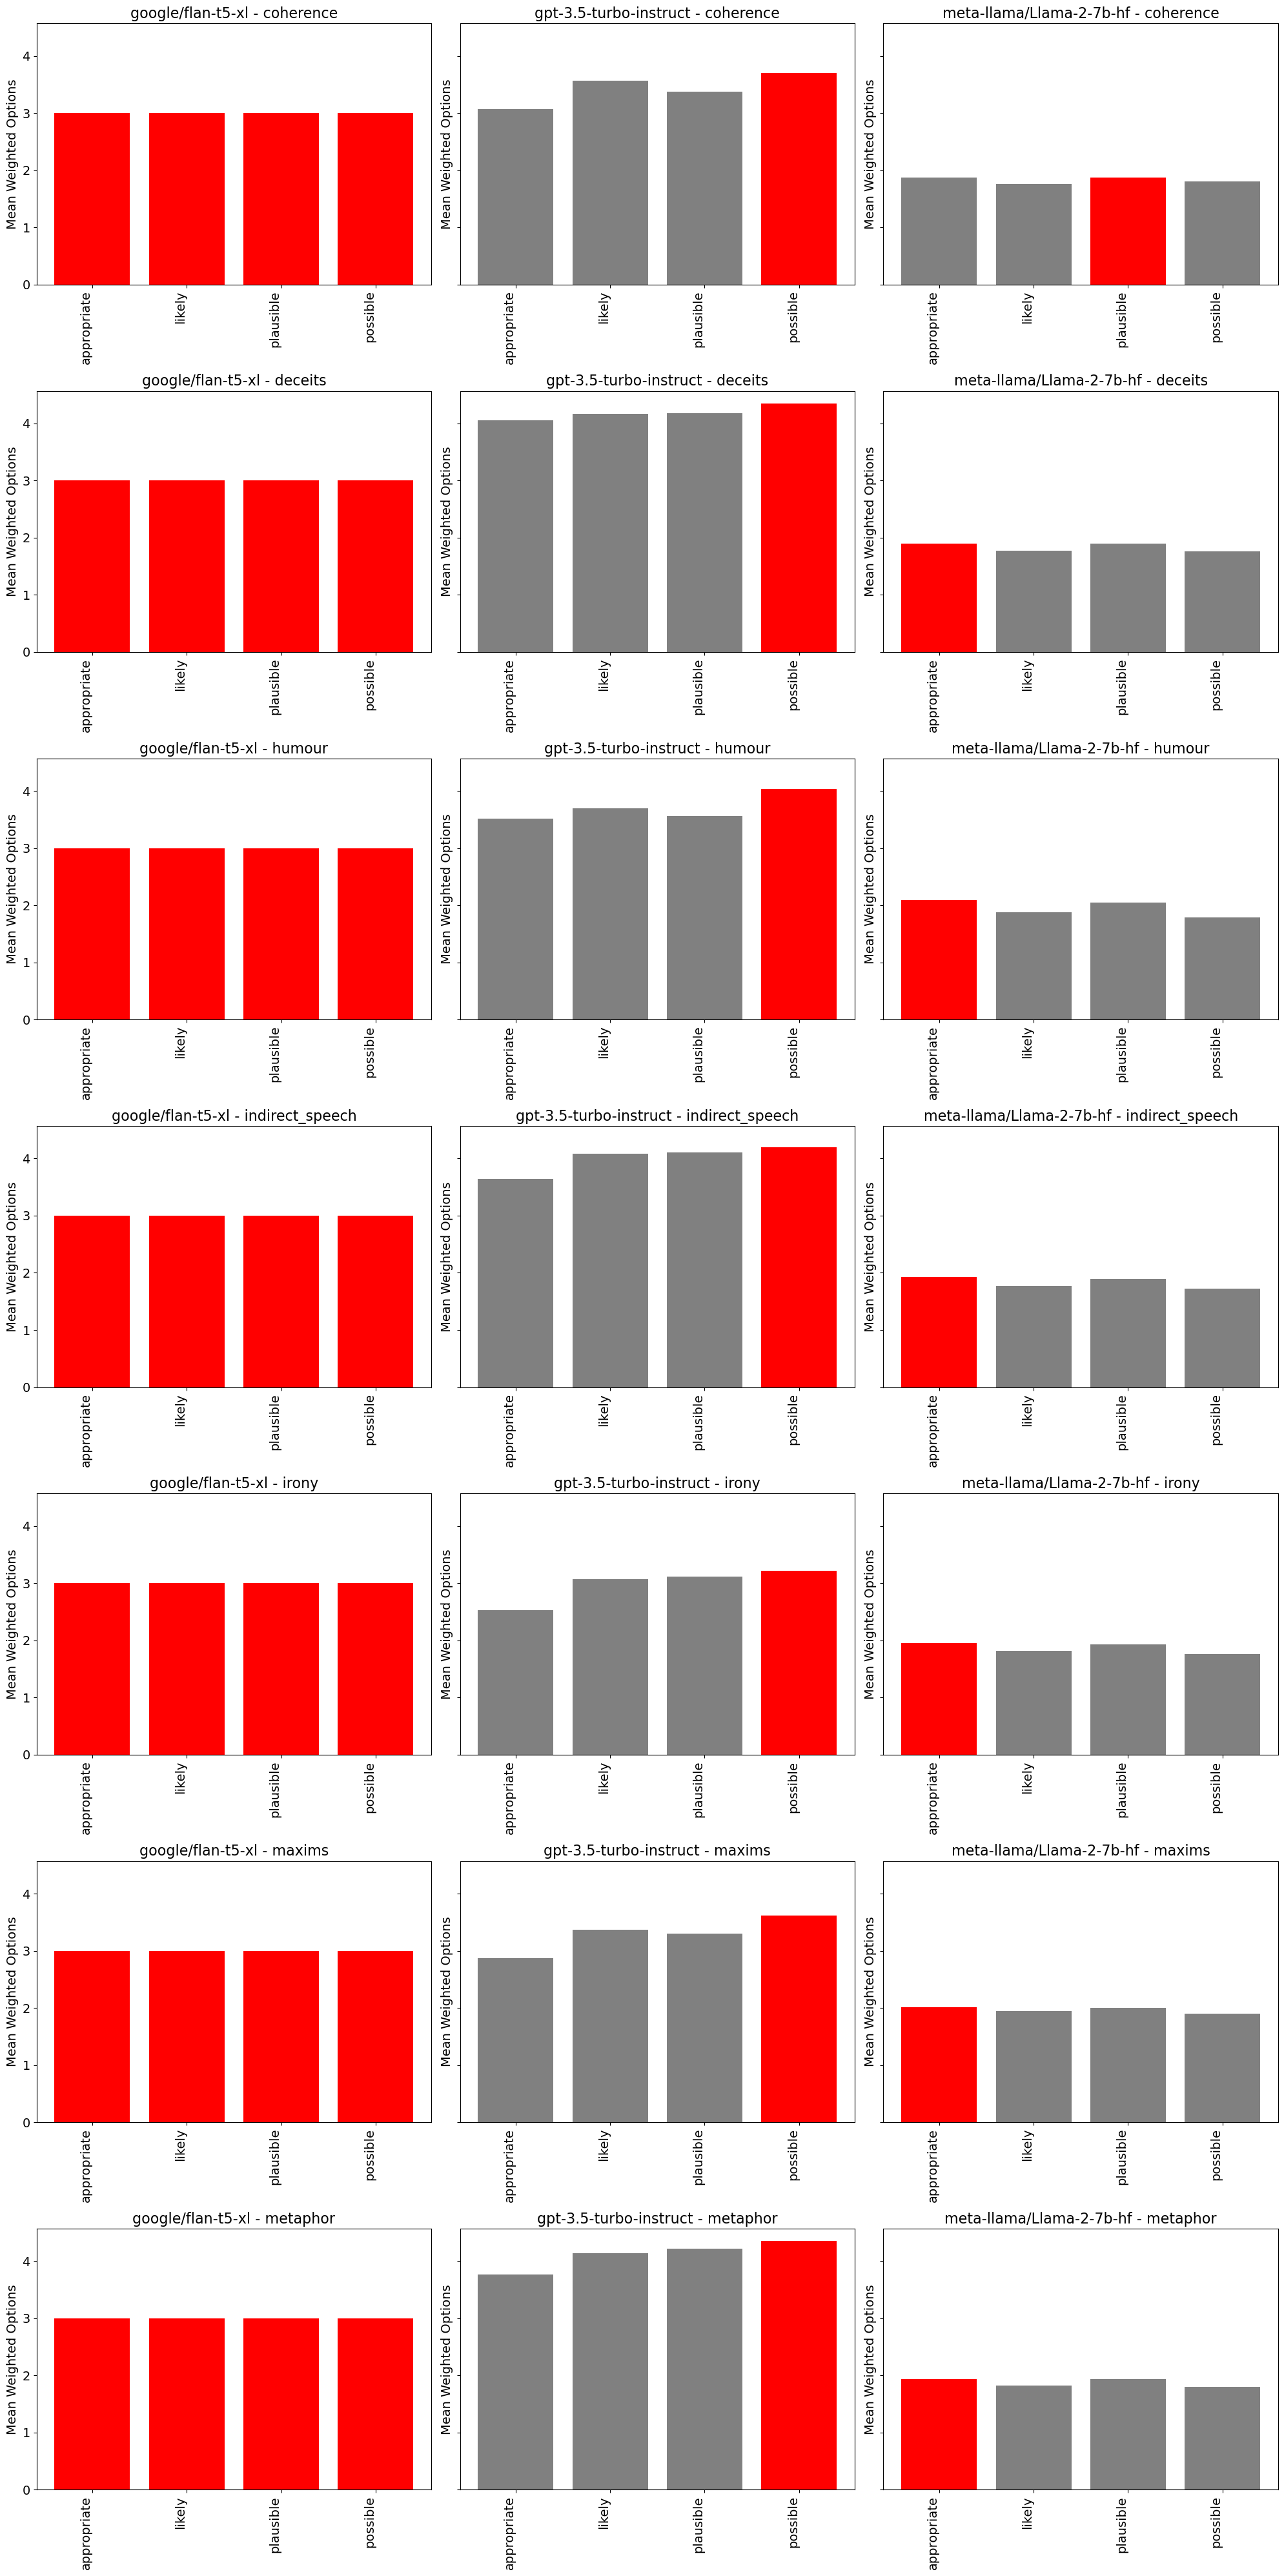

In [43]:
# Manually creating a grid of subplots
fig, axes = plt.subplots(len(unique_phenomena), len(unique_models), figsize=(20, 40), sharey=True)

# Iterating over each model and phenomenon to create individual subplots
for i, phenomenon in enumerate(unique_phenomena):
    for j, model in enumerate(unique_models):
        ax = axes[i, j]
        subset = grouped_target_data[(grouped_target_data['model_name'] == model) & 
                                     (grouped_target_data['phenomenon'] == phenomenon)]
        
        # Determining the bar color based on the highest mean
        colors = ['red' if val == subset['mean'].max() else 'gray' for val in subset['mean']]
        
        ax.bar(subset['scale'], subset['mean'], color=colors)
        ax.set_title(f'Model: {model} | Phenomenon: {phenomenon}')
        ax.set_xlabel('')
        ax.set_ylabel('Mean Weighted Options')

        # Use FixedLocator to set ticks
        ax.xaxis.set_major_locator(FixedLocator(range(len(subset['scale']))))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

       # Remove all lines on background
        ax.grid(False)
        #sns.despine(left=True, bottom=True, ax=ax)

        # Set title with larger font size
        ax.set_title(f"{model} - {phenomenon}", fontsize=16)
        
        # Increase tick label size
        ax.tick_params(axis="x", rotation=90, labelsize=14)
        ax.tick_params(axis="y", labelsize=14)
        
        # Increase axis label size
        ax.set_xlabel(ax.get_xlabel(), fontsize=14)
        ax.set_ylabel(ax.get_ylabel(), fontsize=14)

# Adjust layout
fig.tight_layout()
plt.show()

In [48]:
# Creating a proper name for the plot
plot_name = "rating_w.score_by_scale_model_phenomenon.pdf"
plot_path = os.path.join("plots", plot_name)

# Ensure the plots directory exists
os.makedirs(os.path.dirname(plot_path), exist_ok=True)

# Save the plot
fig.savefig(plot_path)

plot_path


'plots/rating_w.score_by_scale_model_phenomenon.pdf'

In [51]:
# Subsetting the DataFrame based on the specified criteria
subset_df = concatenated_df[(concatenated_df['model_name'] == 'gpt-3.5-turbo-instruct') & 
                            (concatenated_df['scale'] == 'possible')]

# Grouping the subsetted data by the specified columns and calculating the mean for 'weighted_options'
grouped_subset_df = subset_df.groupby(['phenomenon', 'option_names', 'item_id', 'model_name', 'scale'])['weighted_options'].agg(['mean']).reset_index()

grouped_subset_df.head()

print(grouped_subset_df.shape)
print(grouped_subset_df.isnull().sum())
print(grouped_subset_df.head())

(641, 6)
phenomenon      0
option_names    0
item_id         0
model_name      0
scale           0
mean            0
dtype: int64
  phenomenon option_names  item_id              model_name     scale      mean
0  coherence   competitor        1  gpt-3.5-turbo-instruct  possible  3.986833
1  coherence   competitor        2  gpt-3.5-turbo-instruct  possible  4.059427
2  coherence   competitor        3  gpt-3.5-turbo-instruct  possible  3.788843
3  coherence   competitor        4  gpt-3.5-turbo-instruct  possible  3.851727
4  coherence   competitor        5  gpt-3.5-turbo-instruct  possible  4.079559


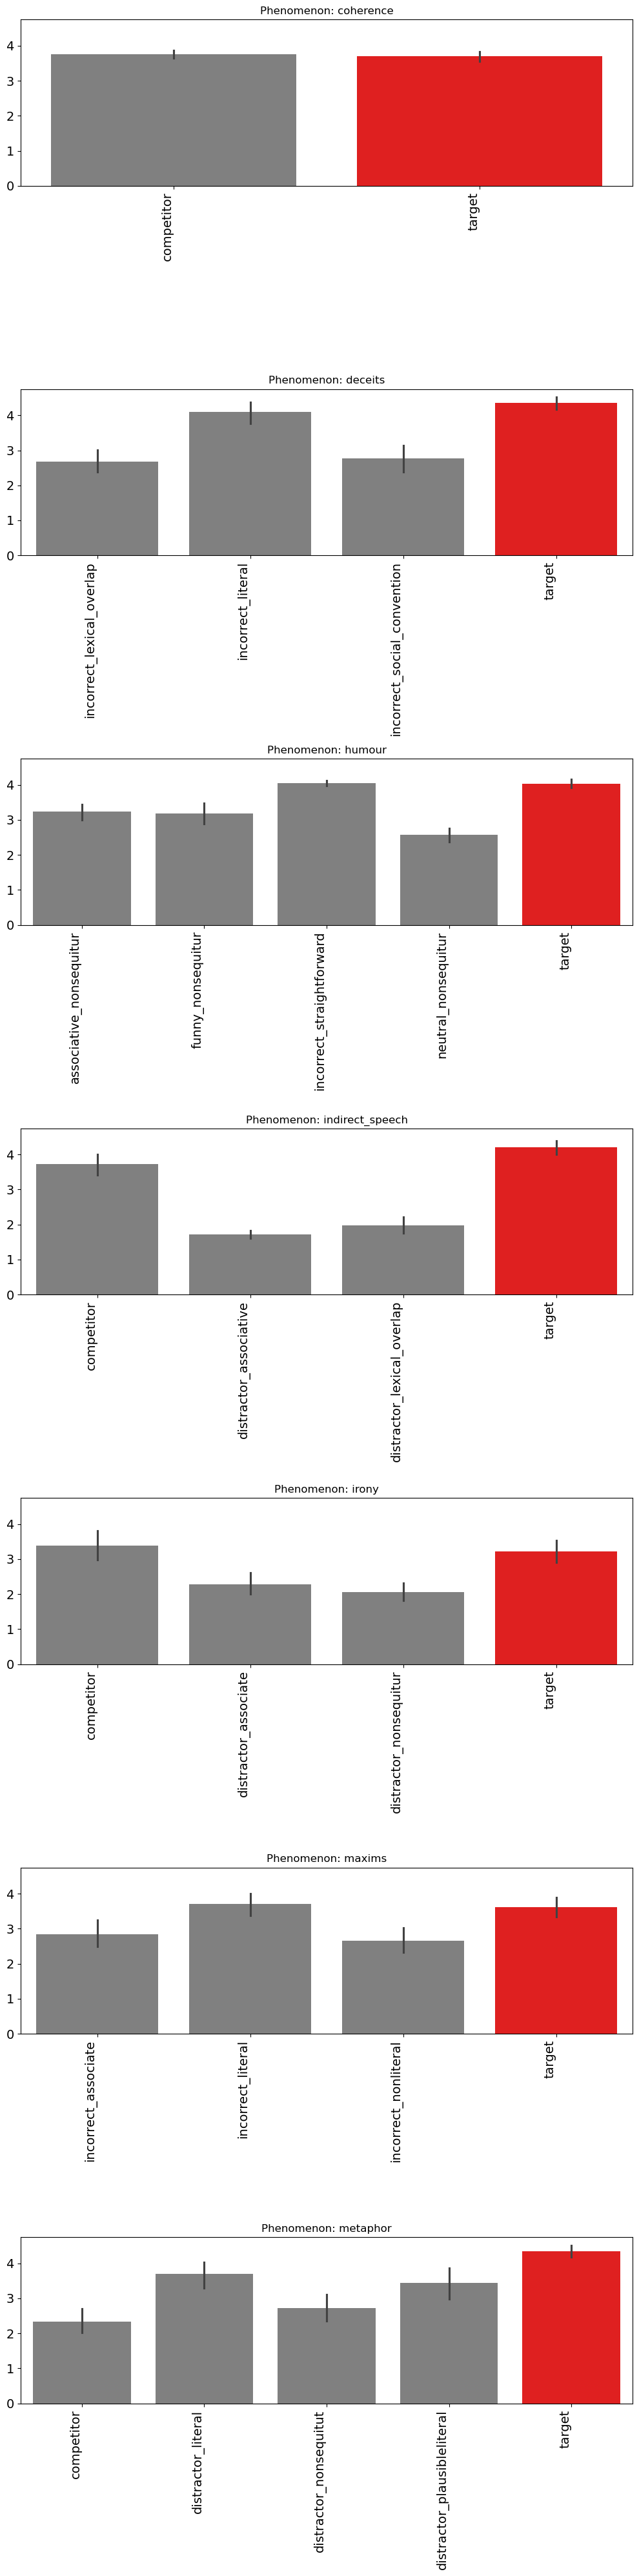

In [76]:
# Extracting unique phenomena from the grouped_subset_df DataFrame
unique_phenomena_subset = grouped_subset_df['phenomenon'].unique()

# Use a custom color palette for different option_names
#palette_subset = sns.color_palette("viridis", len(grouped_subset_df['option_names'].unique()))


# Use a custom color palette to highlight 'target' response_option
palette = {response: 'gray' if response != 'target' else 'red' for response in grouped_subset_df['option_names'].unique()}

# Set up the grid layout for the subplots
fig, axes = plt.subplots(len(unique_phenomena_subset), 1, figsize=(10, 40), sharey=True)

# If there's only one phenomenon, we make axes an array for consistent indexing
if len(unique_phenomena_subset) == 1:
    axes = [axes]

# Iterate over each phenomenon to create individual subplots
for i, phenomenon in enumerate(unique_phenomena_subset):
    ax = axes[i]
    subset = grouped_subset_df[grouped_subset_df['phenomenon'] == phenomenon]
    if not subset.empty:
        colors = ['red' if val == subset['mean'].max() else 'gray' for val in subset['mean']]
        sns.barplot(x='option_names', y='mean', data=subset, ax=ax, palette=palette, hue='option_names')
        #ax.bar(subset['phenomenon'], subset['mean'], color=colors)
        ax.set_ylabel('Mean Weighted Options')
        ax.set_title(f"Phenomenon: {phenomenon}")
        ax.set_xlabel('')
        ax.set_ylabel('')

        # Use FixedLocator to set ticks
        ax.xaxis.set_major_locator(FixedLocator(range(len(subset['option_names'].unique()))))
        ax.set_xticklabels(subset['option_names'].unique(), rotation=45, ha="right")
        #ax.grid(True, axis='y')

        # Remove all lines on background
        ax.grid(False)

        # Increase tick label size
        ax.tick_params(axis="x", rotation=90, labelsize=14)
        ax.tick_params(axis="y", labelsize=14)
        
        # Increase axis label size
        ax.set_xlabel(ax.get_xlabel(), fontsize=14)
        ax.set_ylabel(ax.get_ylabel(), fontsize=14)

# Adjust layout
fig.tight_layout()
plt.show()


In [74]:
# Creating a proper name for the plot
plot_name = "rating_w.score_gpt_possible.pdf"
plot_path = os.path.join("plots", plot_name)

# Ensure the plots directory exists
os.makedirs(os.path.dirname(plot_path), exist_ok=True)

# Save the plot
fig.savefig(plot_path)

plot_path


'plots/rating_w.score_gpt_possible.pdf'